Author: Jimena Gonzalez

In [166]:
script = False
cluster = False

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import timm

import segmentation_models_pytorch as smp

import seaborn as sn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn import preprocessing as p


from PIL import Image, ImageOps
import cv2

from memory_profiler import memory_usage
import random
import os
import gc
from astropy.io import fits

from skimage import io
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

if(script):
    from tqdm import tqdm
else: 
    from tqdm.notebook import tqdm

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [167]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [168]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        
    def transform(self, image, mask):
        """
        might require newest version of pytorch? (pytorch nightly)
        conda install pytorch-nightly::pytorch torchvision torchaudio -c pytorch-nightly
        """
        # Resize
        NUM_PIX = 96
        resize = transforms.Resize(size=(NUM_PIX, NUM_PIX))
        image = resize(image)
        mask = resize(mask)
        
        # Color
        rand_hue = random.random()-0.5
        image = TF.adjust_hue(image, rand_hue)
        mask = TF.adjust_hue(mask, rand_hue)

        # Perspective
        # generate random adjustments to starting coordinates
        rand_end = random.choices(range(0, 21), k=8)
        start_coords = [[0, 0], [0, NUM_PIX], [NUM_PIX, 0], [NUM_PIX, NUM_PIX]]
        # apply random changes to corners for endpoints
        end_coords = [[rand_end[0], rand_end[1]],
                      [rand_end[2], (NUM_PIX-rand_end[3])],
                      [(NUM_PIX-rand_end[4]), rand_end[5]],
                      [NUM_PIX-rand_end[6], NUM_PIX-rand_end[7]]]

        image = TF.perspective(image, start_coords, end_coords)
        mask = TF.perspective(mask, start_coords, end_coords)

        # Rotation
        rand_angle = random.randint(0, 180)
        image = TF.rotate(image, rand_angle)
        mask = TF.rotate(mask, rand_angle)
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
#         # Normalize
#         means = []
#         stds = []
#         for i in range(3):
#             means.append(torch.mean(image[i].flatten()))
#             stds.append(torch.std(image[i].flatten()))
        
#         image = TF.normalize(image, tuple(means), tuple(stds))
#         mask = TF.normalize(mask, (torch.mean(mask.flatten())), (torch.std(mask.flatten())))
        
        return image, mask

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        return sample given index
        """
        # get image and turn into PIL RGB
        image = self.images[idx]
        PIL_image = self.convert_to_rgb(image)
        
        # get label and turn into PIL
        label = self.labels[idx]
        PIL_label = Image.fromarray(label)
        
        random.seed(9)
        
        transformed_image, transformed_label = self.transform(PIL_image, PIL_label)
        
        data_point = self.data.iloc[idx].to_dict()

        sample = {'image': transformed_image, 'label': transformed_label,
                  'img': image, 'data': data_point}

        return sample

    def normalize_image(self, image):
        """
        IMPORTANT: normalizes between 0 and 255 -- NOT 0 and 1
        """
        normed = np.empty((3, 45, 45))
        
        for img in range(3):
            flat = image[img].flatten(order='C')
            for i in range(len(flat)):
                MIN = np.min(image[img])
                MAX = np.max(image[img])
                flat[i] = (flat[i]-MIN)/(MAX-MIN)
                flat[i] = 255.0 * flat[i]

            normed[img] = np.reshape(flat, (45, 45), order='C')

        return normed


    def convert_to_rgb(self, image):
        new_image = np.empty((3, 45, 45))
        new_image = self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = np.uint8(new_image)
        new_image = Image.fromarray(new_image)
        
        return new_image


    def plot_image(self, image):
        new_image = self.convert_to_rgb(image)

        plt.figure(figsize=(10,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.imshow(new_image, aspect='equal')
        plt.axis('off')
        
        plt.show()
        plt.close()

In [171]:
seed_everything(9)

if(cluster):
    path = '/home/gcartwright/Segmentation/Image_Segmentation/' # OSG home
else:
    path = '/Users/gilliancartwright/Desktop/Research/Segmentation/Image-Segmentation/' #local
    

npos = 4000

num_workers = 0
num_epochs = 8


hdu_list = fits.open(path + 'labeled_file.fits')
print(len(hdu_list[1].data))
idx = random.sample(range(len(hdu_list[1].data)), npos)
images = hdu_list[2].data[idx,:] 
images = images.astype(np.float32)
labels = hdu_list[5].data[idx,:] 
labels = labels.astype(np.float32)
data = pd.DataFrame(hdu_list[7].data[:][idx])
data = data.drop('TILENAME', axis=1)
hdu_list.close()

print(images.shape, labels.shape)

4000
(4000, 3, 45, 45) (4000, 45, 45)


In [172]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    #y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=None),
            ImageDataset(test_images, test_data, test_labels, transform=None))

In [173]:
train_dataset, other_dataset = make_train_test_datasets(images, data, labels, test_size=0.2, transform=None)
valid_dataset, test_dataset = make_train_test_datasets(other_dataset.images, other_dataset.data, other_dataset.labels, test_size=0.5, transform=None)
print('Len train dataset: {}, len test dataset: {}'.format(len(train_dataset), len(test_dataset)))

Len train dataset: 3200, len test dataset: 400


In [174]:
def show_training_set(train_dataset, idx):
    loc = plticker.MultipleLocator(base=3.75)
    fig, ax = plt.subplots(figsize=(15, 4), ncols=3)

    orig_rgb = make_lupton_rgb(train_dataset[idx]['img'][0],
                               train_dataset[idx]['img'][1],
                               train_dataset[idx]['img'][2], Q=11., stretch=40.)

    ax[0].set_title('Original Image')
    ax[0].xaxis.set_ticklabels([])
    ax[0].yaxis.set_ticklabels([])
    ax[0].imshow(orig_rgb, aspect='equal')

    new_rgb = make_lupton_rgb(np.array(train_dataset[idx]['image'][0]),
                              np.array(train_dataset[idx]['image'][1]),
                              np.array(train_dataset[idx]['image'][2]), stretch=1., Q=1.) #minimunm=-0.5

    ax[1].set_title('Transformed Image')
    ax[1].xaxis.set_ticklabels([])
    ax[1].yaxis.set_ticklabels([])
    ax[1].imshow(new_rgb, aspect='equal')

    ax[2].set_title('Training Label')
    ax[2].xaxis.set_ticklabels([])
    ax[2].yaxis.set_ticklabels([])
    ax[2].imshow(np.array(train_dataset[idx]['label'][0]), aspect='equal')

    plt.show()
    plt.close()


In [175]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=5, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=5, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, num_workers=num_workers, shuffle=True)
torch.save(test_loader, 'test_loader.pth')

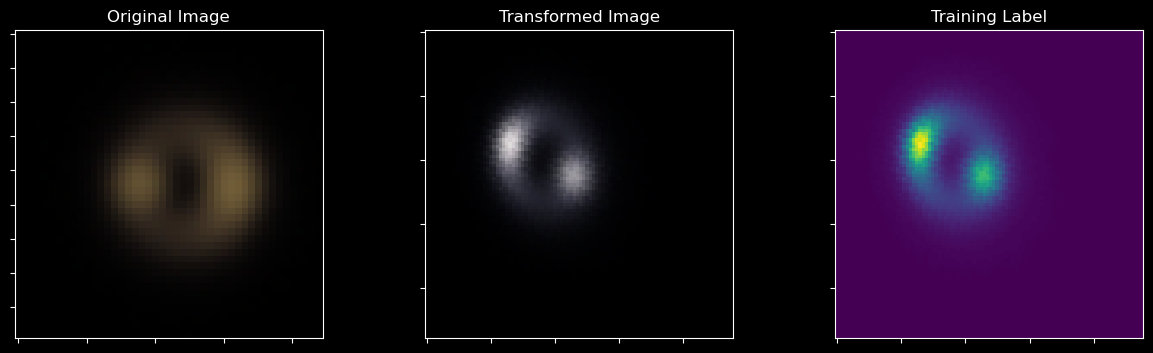

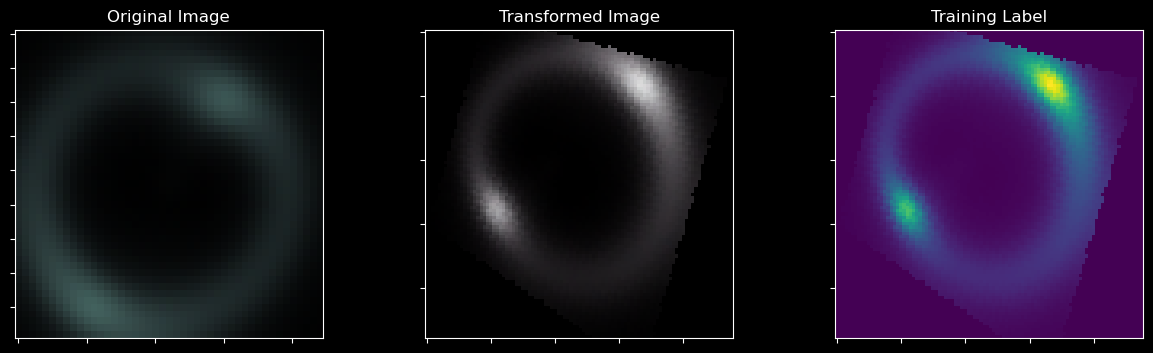

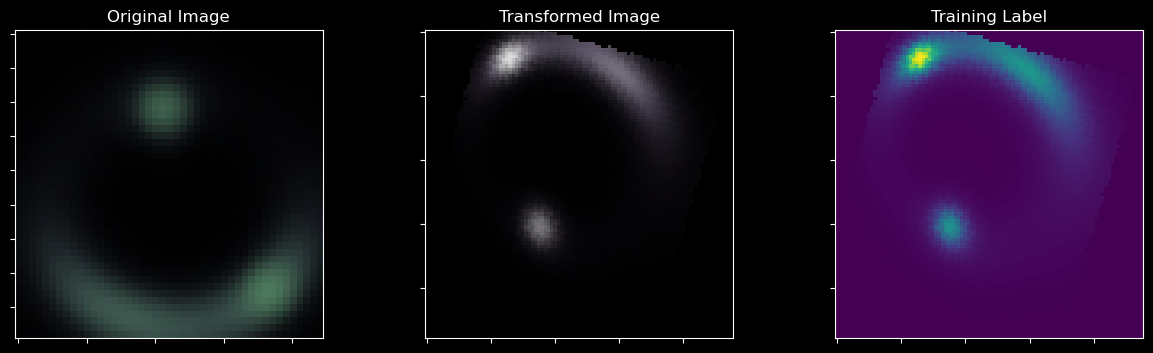

In [176]:
for idx in range(3):
    show_training_set(train_dataset, idx)

In [177]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        #self.model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
        self.model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1)
        
        if(not cluster):
            self.model = smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=1)
            torch.save(self.model.state_dict(), 'initial_model.pt')
        else:
            #self.model = EfficientNet.from_name('efficientnet-b0',  num_classes=n_classes)
            self.model = smp.Unet(encoder_name="resnet50", in_channels=3, classes=1)
            self.model.load_state_dict(torch.load('initial_model.pt'))
        
    def forward(self, x):

        x = self.model(x)

        return x

    def pseudo_accuracy(self, output, target):
        output = torch.sigmoid(output)
        num = target.size(0)
        m1 = output.view(num, -1)  # Flatten
        m2 = target.view(num, -1)  # Flatten
        intersection = (m1 * m2).sum()#(dim=1)
        #accu = intersection.item()*100/(96*96*num)
        return(2. * intersection + 1.) / (m1.sum() + m2.sum() + 1.)
        
    
    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################

        self.model.train()

        #for i, (data, target, sample_img, sample_data) in tqdm(enumerate(train_loader)):
        for i, sample in enumerate(tqdm(train_loader)):

            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            #output = torch.squeeze(output)

            #target = target.float()
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Calculate Accuracy
            #accuracy = (output.argmax(dim=1) == target).float().mean()
            accuracy = self.pseudo_accuracy(output, target)
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            optimizer.step()

        return epoch_loss / len(train_loader.dataset), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for i, sample in enumerate(tqdm(valid_loader)):
            data, target, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
            
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                #accuracy = (output.argmax(dim=1) == target).float().mean()
                #accuracy = sum(output.argmax(dim=1) == target)
                accuracy = self.pseudo_accuracy(output, target)
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader.dataset), valid_accuracy / len(valid_loader)


In [178]:
model = ViTBase16(n_classes=9, pretrained=True)

criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss() #nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


cpu


In [179]:
def fit_tpu(model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None):
    
    best_val_acc = 0.0 # track of best accuracy

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        
        print(f"{'=' * 100}")
        print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(train_loader, criterion, optimizer, device)
        print(f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        # moves towards valid_loader
        print("start valid_loader")

        if valid_loader is not None:
            gc.collect()
            print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(valid_loader, criterion, device)
            print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            if(valid_acc > best_val_acc):
                setattr(model, 'loss_train', train_losses)
                setattr(model, 'loss_valid', valid_losses)
                setattr(model, 'train_acc', train_accs)
                setattr(model, 'validation_acc', valid_accs)
                torch.save(model, name_model)
                best_val_acc = valid_acc

In [180]:
def plot_performance(cnn):
    loss_train = [x.item() for x in cnn.loss_train]
    loss_valid = [x.item() for x in cnn.loss_valid]
    train_acc = [x.item() for x in cnn.train_acc]
    valid_acc = [x.item() for x in cnn.validation_acc]
    
    x = np.linspace(1,len(cnn.loss_train),len(cnn.loss_train))
    fig, (ax1, ax2) = plt.subplots(figsize=(16, 7), ncols=2)
    
    ax1.set_title('Losses')
    ax1.set_xlabel('Epoch')
    ax1.scatter(x, loss_train, color = 'skyblue', alpha = 0.8, label = 'Training loss')
    ax1.scatter(x, loss_valid, color = 'limegreen', alpha = 0.8,  label = 'Validation loss')
    ax1.legend()
    
    ax2.set_title('Performance. Max: {:.4f}%'.format(100*cnn.validation_acc[-1].item()))
    ax2.set_xlabel('Epoch')
    ax2.scatter(x, train_acc, color = 'skyblue', alpha = 0.8,  label = 'Training Accuracy')
    ax2.scatter(x, valid_acc, color = 'limegreen', alpha = 0.8,  label = 'Validation Accuracy')
    ax2.legend()
    
    if(script):
        plt.savefig('Performance.png', bbox_inches='tight')
        plt.close()
    else: 
        plt.show(block=True)
    

In [181]:
name_model = 'model.pt'
# model, name_model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
mem_usage = memory_usage(( fit_tpu, (model, name_model, num_epochs,
                                     device, criterion, optimizer, train_loader, valid_loader)))


EPOCH 1 - TRAINING...


  0%|          | 0/640 [00:00<?, ?it/s]


	[TRAIN] EPOCH 1 - LOSS: 0.048112932592630386, ACCURACY: 0.2232402265071869

start valid_loader
EPOCH 1 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.02808327041566372, ACCURACY: 0.29747191071510315

EPOCH 2 - TRAINING...


  0%|          | 0/640 [00:00<?, ?it/s]


	[TRAIN] EPOCH 2 - LOSS: 0.025651151314377785, ACCURACY: 0.32920899987220764

start valid_loader
EPOCH 2 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.024691924452781677, ACCURACY: 0.3537931442260742

EPOCH 3 - TRAINING...


  0%|          | 0/640 [00:00<?, ?it/s]


	[TRAIN] EPOCH 3 - LOSS: 0.024105507880449295, ACCURACY: 0.3588502109050751

start valid_loader
EPOCH 3 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.0242164246737957, ACCURACY: 0.34931546449661255

EPOCH 4 - TRAINING...


  0%|          | 0/640 [00:00<?, ?it/s]


	[TRAIN] EPOCH 4 - LOSS: 0.023676199838519096, ACCURACY: 0.368169903755188

start valid_loader
EPOCH 4 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.024115048348903656, ACCURACY: 0.35568833351135254

EPOCH 5 - TRAINING...


  0%|          | 0/640 [00:00<?, ?it/s]


	[TRAIN] EPOCH 5 - LOSS: 0.023552747443318367, ACCURACY: 0.37184247374534607

start valid_loader
EPOCH 5 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.02398412674665451, ACCURACY: 0.37647154927253723

EPOCH 6 - TRAINING...


  0%|          | 0/640 [00:00<?, ?it/s]


	[TRAIN] EPOCH 6 - LOSS: 0.02346215397119522, ACCURACY: 0.37284690141677856

start valid_loader
EPOCH 6 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.02389351651072502, ACCURACY: 0.3750947117805481

EPOCH 7 - TRAINING...


  0%|          | 0/640 [00:00<?, ?it/s]


	[TRAIN] EPOCH 7 - LOSS: 0.023386336863040924, ACCURACY: 0.3736293911933899

start valid_loader
EPOCH 7 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.02393009141087532, ACCURACY: 0.35423582792282104

EPOCH 8 - TRAINING...


  0%|          | 0/640 [00:00<?, ?it/s]


	[TRAIN] EPOCH 8 - LOSS: 0.023356162011623383, ACCURACY: 0.37401628494262695

start valid_loader
EPOCH 8 - VALIDATING...


  0%|          | 0/80 [00:00<?, ?it/s]

	[VALID] LOSS: 0.02392570674419403, ACCURACY: 0.36490756273269653



In [182]:
print('Maximum memory usage: %s' % max(mem_usage))


Maximum memory usage: 2244.3046875


In [183]:
name = 'model.pt'
model = torch.load(name, map_location=torch.device('cpu'))
print('Maximum validation accuracy: {:.2f}%'.format(100*model.validation_acc[-1].item()))

test_loader = torch.load('test_loader.pth')

Maximum validation accuracy: 37.65%


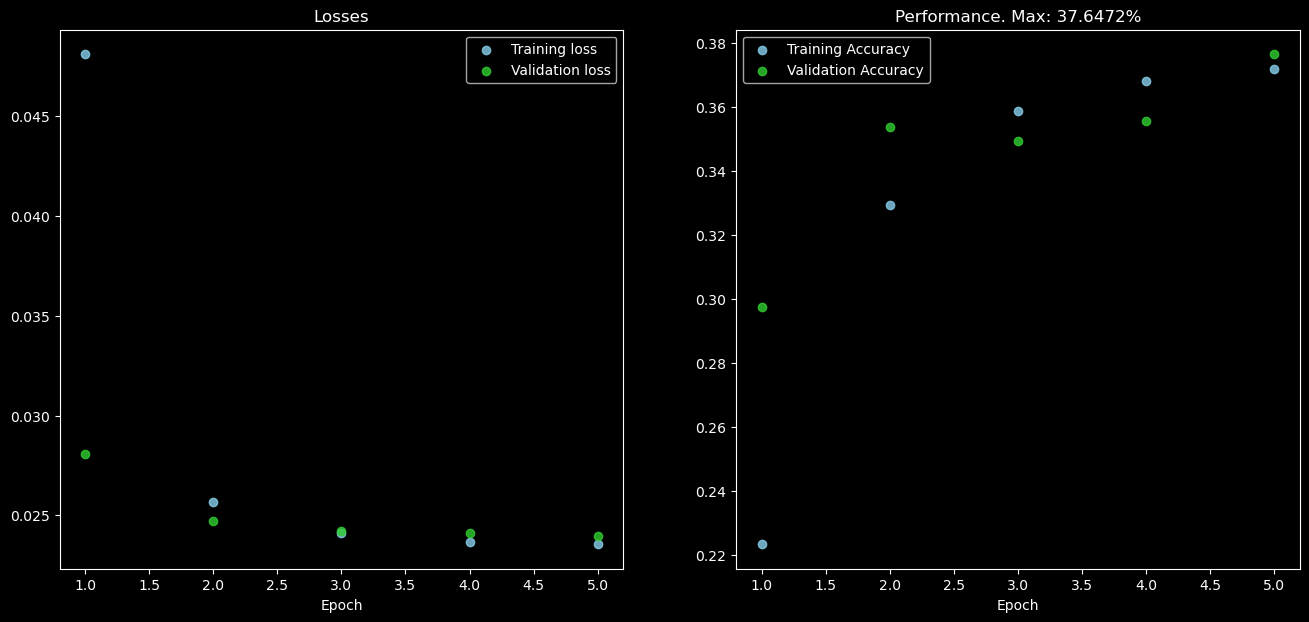

In [184]:
plot_performance(model)

In [207]:
def make_graphs(name, image, label, predicted_label):    
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)

    rgb = make_lupton_rgb(image[2], image[1], image[0], Q=1., stretch=1.)
    ax1.set_title('Image')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    original = ax1.imshow(rgb, aspect='equal')
    
    img2 = ax2.imshow(label[0][0].detach().numpy())
    ax2.set_title('True Label')
    plt.colorbar(img2, ax=ax2)
    #ax2.axis('off')
    
    img3 = ax3.imshow(predicted_label[0][0].detach().numpy())
    ax3.set_title('Predicted')
    plt.colorbar(img3, ax=ax3)
    #ax2.axis('off')
   
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()

In [211]:
def testing_analysis(accu_lim, test_loader):
    right_pos_img, wrong_pos_img = np.zeros((1,3,45,45)), np.zeros((1,3,45,45))
    right_neg_img, wrong_neg_img = np.zeros((1,3,45,45)), np.zeros((1,3,45,45))

    for i_batch, sample in enumerate(tqdm(test_loader)):
        if(i_batch == 10): break
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
        if device.type == "cuda":
            sample_image, sample_label = sample_image.cuda(), sample_label.cuda()
        
        output = model(sample_image)  
        output = torch.sigmoid(output)
        if(not cluster):
            sample_img = sample_img[0]
            make_graphs('name', sample_image[0], sample_label, output)


  0%|          | 0/400 [00:00<?, ?it/s]

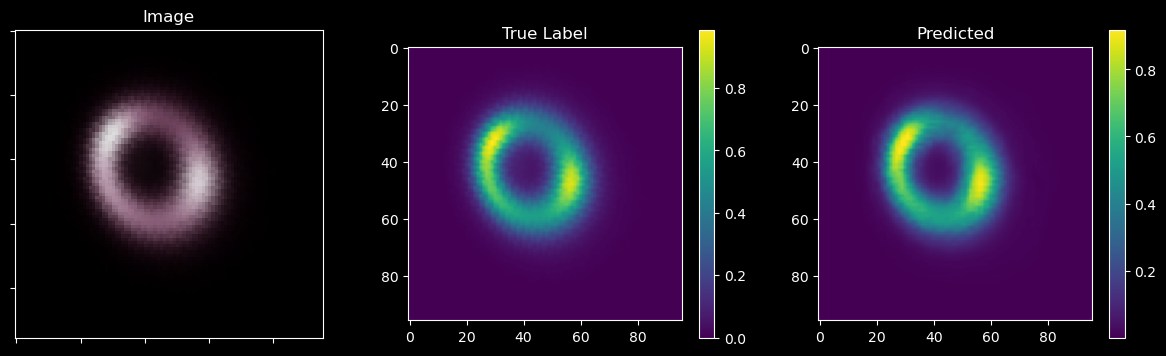

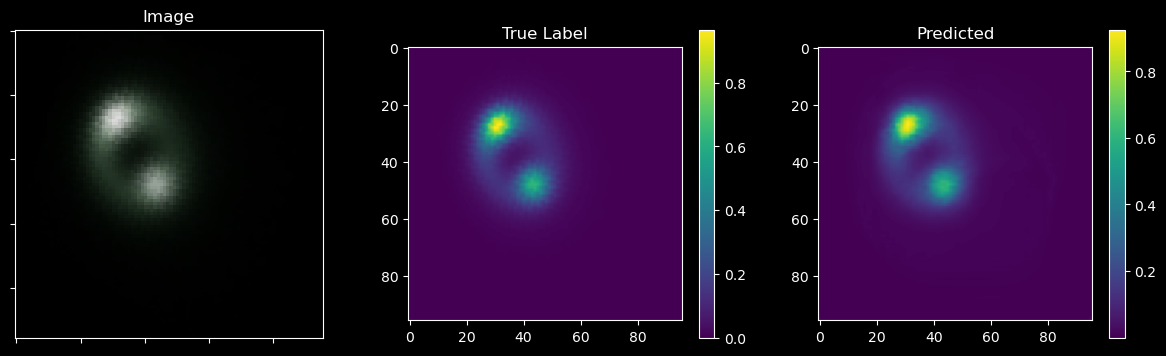

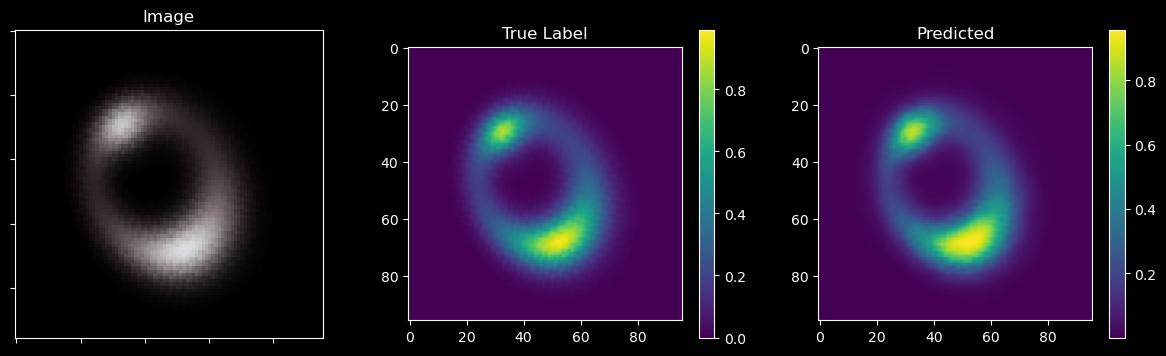

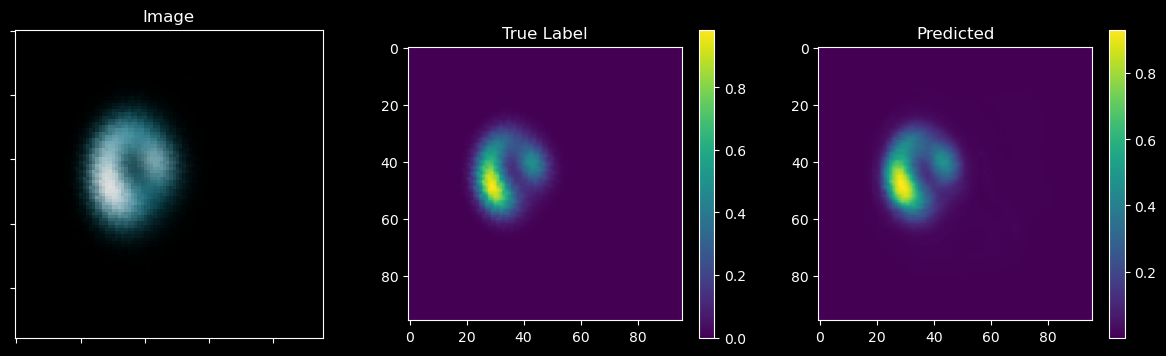

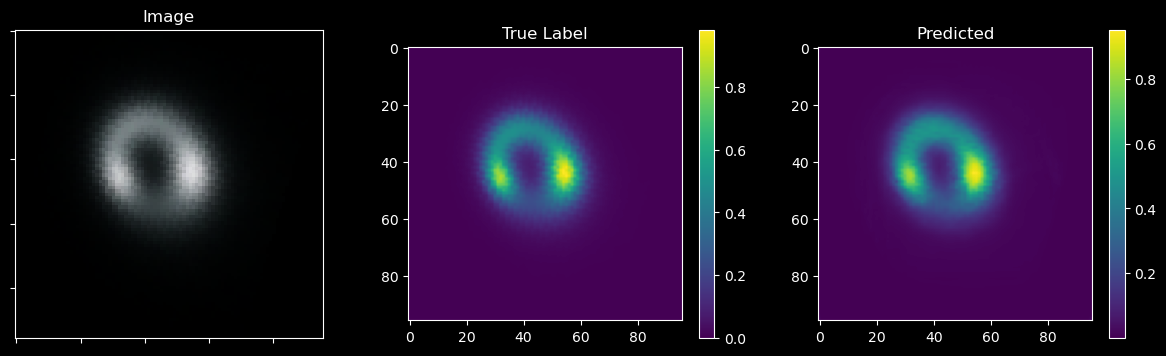

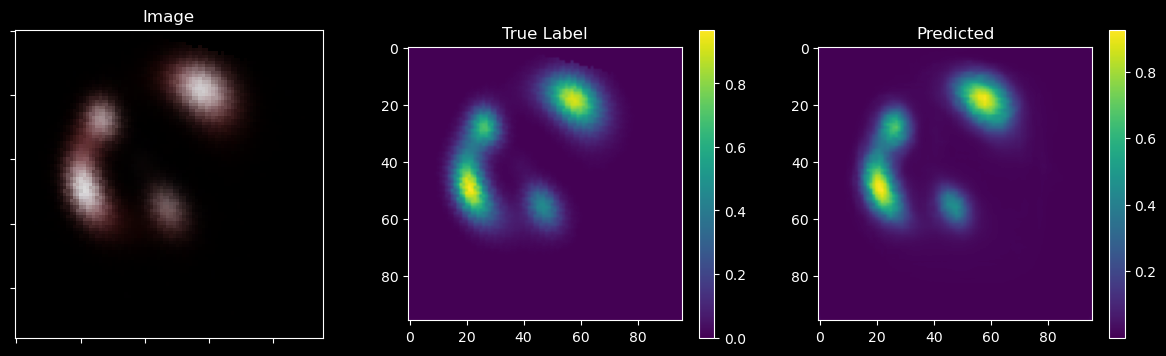

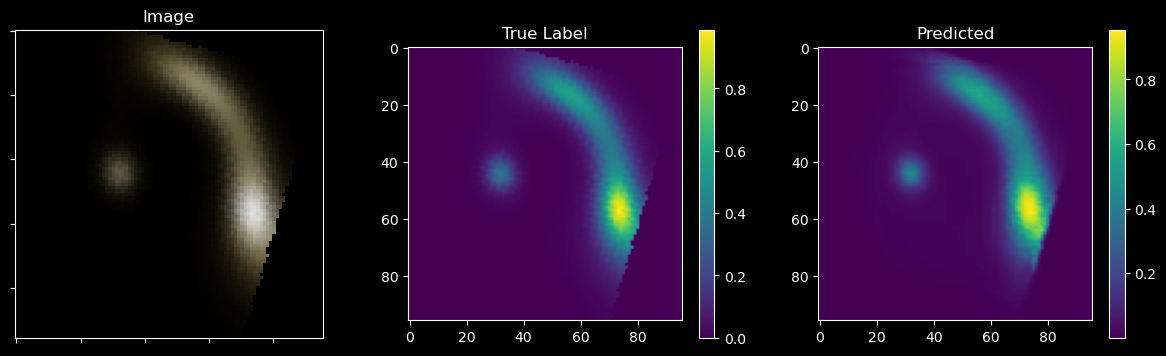

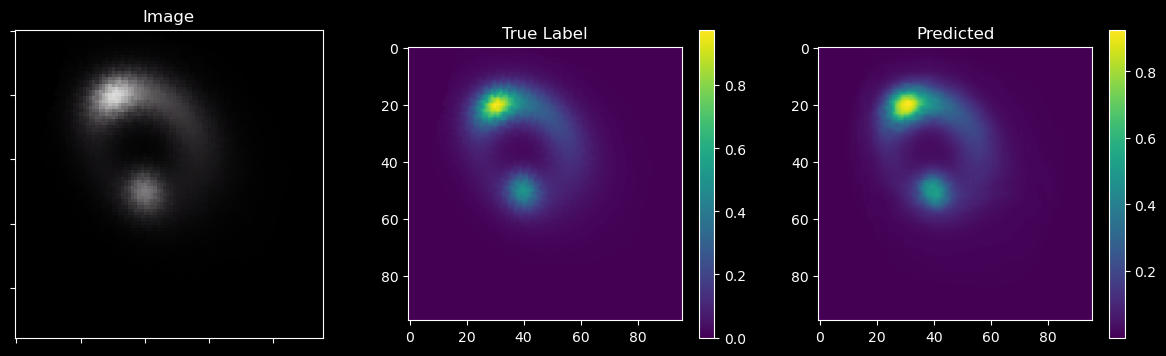

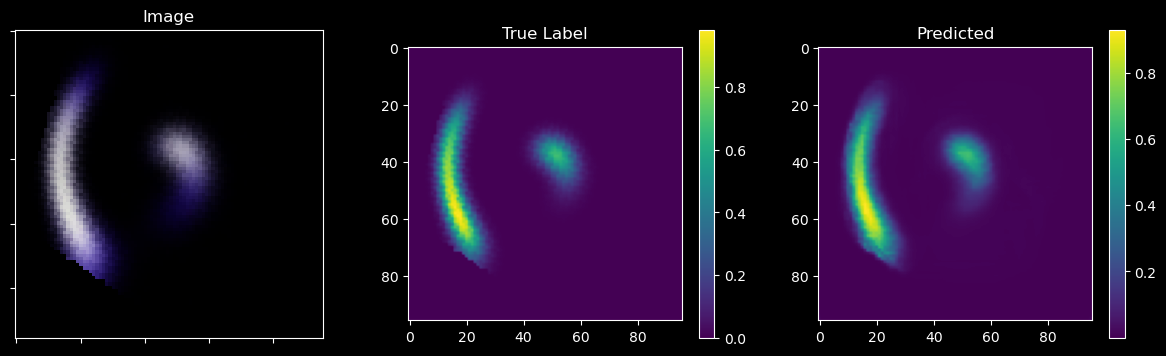

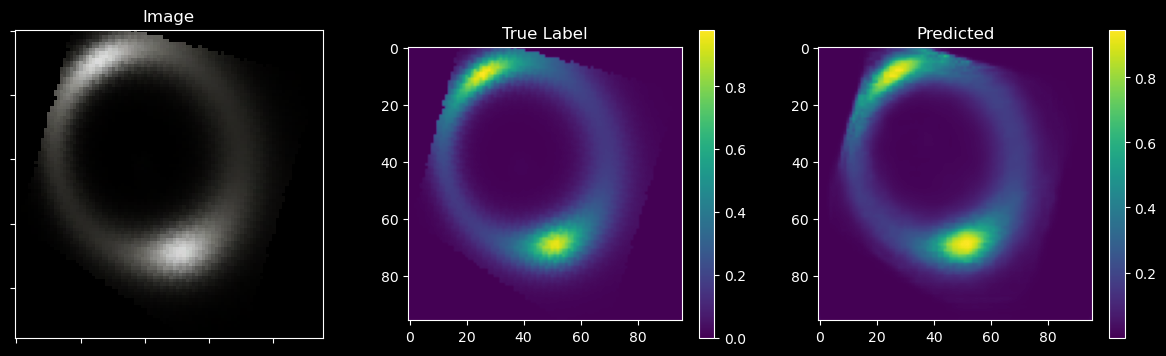

In [212]:
testing_analysis(0.5, test_loader)


In [213]:
plt.close('all')